## Fake_News_Detection project
 

### Monika singh 

Fake news has become one of the biggest problems of our age. It has serious impact on our online as well as offline discourse. One can even go as far as saying that, to date, fake news poses a clear and present danger to western democracy and stability of the society. Fake news's simple meaning is to incorporate information that leads people to the wrong path. Nowadays fake news spreading like water and people share this information without verifying it. This is often done to further or impose certain ideas and is often achieved with political agendas.
For media outlets, the ability to attract viewers to their websites is necessary to generate online advertising revenue. So it is necessary to detect fake news.



## Importing libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn import feature_extraction, linear_model, model_selection, preprocessing
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

## Read datasets

In [4]:
fake = pd.read_csv("Fake.csv")
true = pd.read_csv("True.csv")

In [5]:
fake.shape

(23481, 4)

In [6]:
true.shape

(21417, 4)

## Data cleaning and preparation

In [7]:
# Add flag to track fake and real
fake['target'] = '0'
true['target'] = '1'

In [8]:
# Concatenate dataframes
data = pd.concat([fake, true]).reset_index(drop = True)
data.shape

(44898, 5)

In [9]:
# Shuffle the data
from sklearn.utils import shuffle
data = shuffle(data)
data = data.reset_index(drop=True)

In [10]:
# Check the data
data.head()

,title,text,subject,date,target
0,Trump Wanted To Attack The LGBTQ Community; J...,"Earlier in the week, there were leaked draft e...",News,"February 3, 2017",0
1,U.S. Interior Secretary investigated over spee...,WASHINGTON (Reuters) - The U.S. Office of Spec...,politicsNews,"October 3, 2017",1
2,Jordan border crossing with Iraq to reopen in ...,AMMAN (Reuters) - Jordan will open its main bo...,worldnews,"August 29, 2017",1
3,PRESIDENT TRUMP Hits Back At Activist Judge On...,Judge Orrick in California ruled against Presi...,politics,"Apr 26, 2017",0
4,Patrick Henningsen LIVE with guest Sean Stone ...,Join Patrick every week here at 21WIRE.TV for ...,US_News,"December 8, 2016",0


In [11]:
# Removing the date (we won't use it for the analysis)
data.drop(["date"],axis=1,inplace=True)
data.head()

,title,text,subject,target
0,Trump Wanted To Attack The LGBTQ Community; J...,"Earlier in the week, there were leaked draft e...",News,0
1,U.S. Interior Secretary investigated over spee...,WASHINGTON (Reuters) - The U.S. Office of Spec...,politicsNews,1
2,Jordan border crossing with Iraq to reopen in ...,AMMAN (Reuters) - Jordan will open its main bo...,worldnews,1
3,PRESIDENT TRUMP Hits Back At Activist Judge On...,Judge Orrick in California ruled against Presi...,politics,0
4,Patrick Henningsen LIVE with guest Sean Stone ...,Join Patrick every week here at 21WIRE.TV for ...,US_News,0


In [12]:
# Removing the title (we will only use the text)
data.drop(["title"],axis=1,inplace=True)
data.head()

,text,subject,target
0,"Earlier in the week, there were leaked draft e...",News,0
1,WASHINGTON (Reuters) - The U.S. Office of Spec...,politicsNews,1
2,AMMAN (Reuters) - Jordan will open its main bo...,worldnews,1
3,Judge Orrick in California ruled against Presi...,politics,0
4,Join Patrick every week here at 21WIRE.TV for ...,US_News,0


In [13]:
# Convert to lowercase

data['text'] = data['text'].apply(lambda x: x.lower())
data.head()

,text,subject,target
0,"earlier in the week, there were leaked draft e...",News,0
1,washington (reuters) - the u.s. office of spec...,politicsNews,1
2,amman (reuters) - jordan will open its main bo...,worldnews,1
3,judge orrick in california ruled against presi...,politics,0
4,join patrick every week here at 21wire.tv for ...,US_News,0


In [14]:
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

data['text'] = data['text'].apply(punctuation_removal)

In [15]:
# Check
data.head()

,text,subject,target
0,earlier in the week there were leaked draft ex...,News,0
1,washington reuters the us office of special c...,politicsNews,1
2,amman reuters jordan will open its main borde...,worldnews,1
3,judge orrick in california ruled against presi...,politics,0
4,join patrick every week here at 21wiretv for n...,US_News,0


## Basic data exploration

subject
Government News     1570
Middle-east          778
News                9050
US_News              783
left-news           4459
politics            6841
politicsNews       11272
worldnews          10145
Name: text, dtype: int64


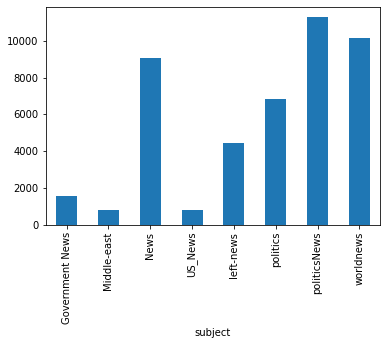

In [18]:
# How many articles per subject?
print(data.groupby(['subject'])['text'].count())
data.groupby(['subject'])['text'].count().plot(kind="bar")
plt.show()

target
0    23481
1    21417
Name: text, dtype: int64


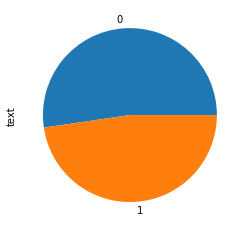

In [19]:
# How many fake and real articles?
print(data.groupby(['target'])['text'].count())
data.groupby(['target'])['text'].count().plot(kind="pie")
plt.show()

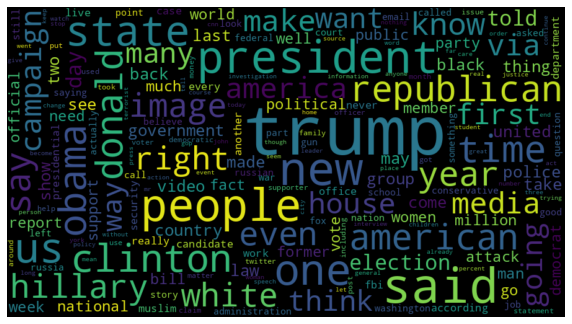

In [20]:
# Word cloud for fake news
from wordcloud import WordCloud

fake_data = data[data["target"] == "0"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 900, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

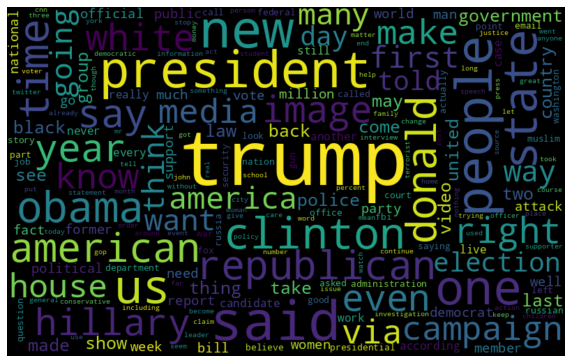

In [21]:
# Word cloud for real news
from wordcloud import WordCloud

real_data = data[data["target"] == "1"]
all_words = ' '.join([text for text in fake_data.text])

wordcloud = WordCloud(width= 800, height= 500,
                          max_font_size = 110,
                          collocations = False).generate(all_words)

plt.figure(figsize=(10,7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [22]:
# Most frequent words counter   
from nltk import tokenize

token_space = tokenize.WhitespaceTokenizer()

def counter(text, column_text, quantity):
    all_words = ' '.join([text for text in text[column_text]])
    token_phrase = token_space.tokenize(all_words)
    frequency = nltk.FreqDist(token_phrase)
    df_frequency = pd.DataFrame({"Word": list(frequency.keys()),
                                   "Frequency": list(frequency.values())})
    df_frequency = df_frequency.nlargest(columns = "Frequency", n = quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

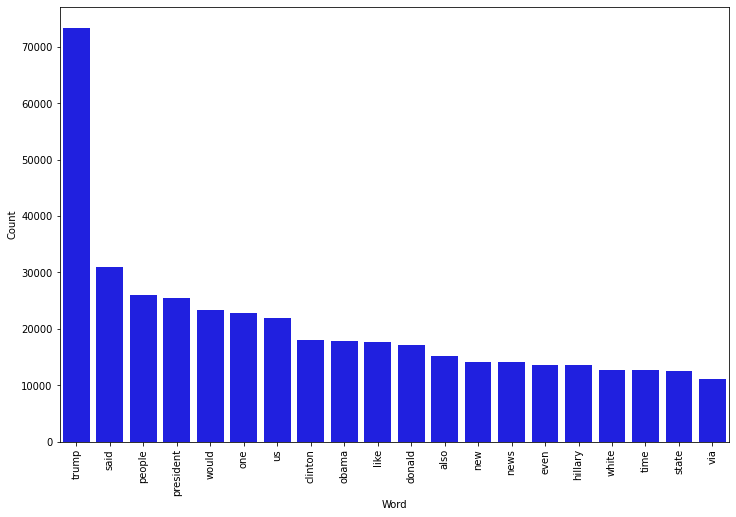

In [23]:
# Most frequent words in fake news
counter(data[data["target"] == "0"], "text", 20)

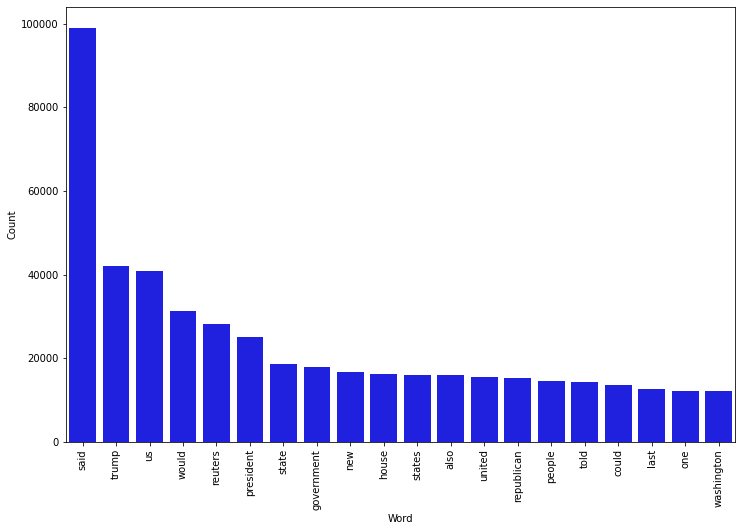

In [24]:
# Most frequent words in real news
counter(data[data["target"] == "1"], "text", 20)

## Modeling

In [25]:
# Function to plot the confusion matrix 
from sklearn import metrics
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### preparing data

In [26]:
# Split the data
X_train,X_test,y_train,y_test = train_test_split(data['text'], data.target, test_size=0.2, random_state=42)

# **Naive Bayes**




In [27]:
dct = dict()

from sklearn.naive_bayes import MultinomialNB

NB_classifier = MultinomialNB()
pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', NB_classifier)])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))

dct['Naive Bayes'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 95.69%


Confusion matrix, without normalization


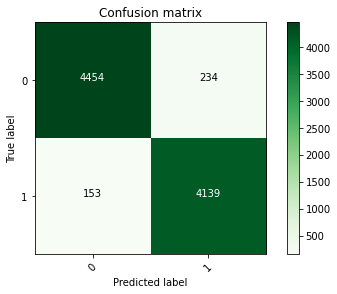

In [28]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['0', '1'])

# **Logistic regression**

In [29]:
# Vectorizing and applying TF-IDF
from sklearn.linear_model import LogisticRegression

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', LogisticRegression())])

# Fitting the model
model = pipe.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Logistic Regression'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.02%


Confusion matrix, without normalization


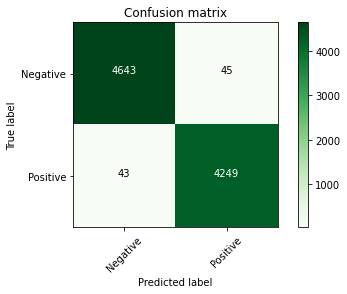

In [30]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

# **Decision Tree**

In [31]:
from sklearn.tree import DecisionTreeClassifier

# Vectorizing and applying TF-IDF
pipe1 = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', DecisionTreeClassifier(criterion= 'entropy',
                                           max_depth = 20, 
                                           splitter='best', 
                                           random_state=42))])
# Fitting the model
model = pipe1.fit(X_train, y_train)

# Accuracy
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Decision Tree'] = round(accuracy_score(y_test, prediction)*100,2)

accuracy: 99.6%


Confusion matrix, without normalization


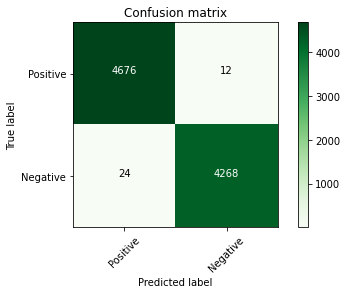

In [32]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Positive', 'Negative'])

# **Random Forest**

In [33]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline([('vect', CountVectorizer()),
                 ('tfidf', TfidfTransformer()),
                 ('model', RandomForestClassifier(n_estimators=50, criterion="entropy"))])

model = pipe.fit(X_train, y_train)
prediction = model.predict(X_test)
print("accuracy: {}%".format(round(accuracy_score(y_test, prediction)*100,2)))
dct['Random Forest'] = round(accuracy_score(y_test, prediction)*100,2)


accuracy: 99.0%


Confusion matrix, without normalization


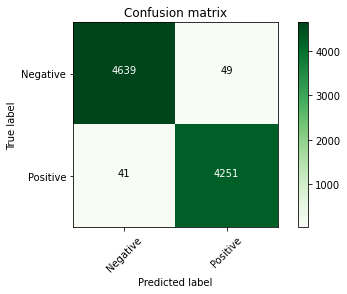

In [34]:
cm = metrics.confusion_matrix(y_test, prediction)
plot_confusion_matrix(cm, classes=['Negative', 'Positive'])

# **Comparing** **Different Models**

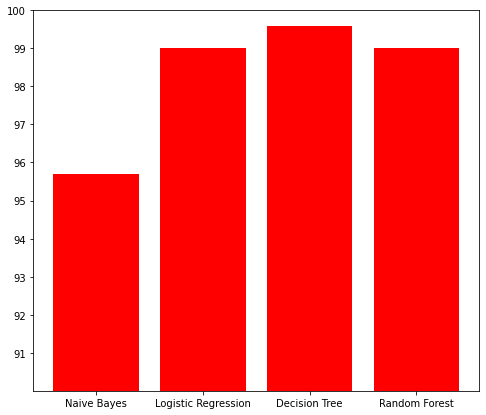

In [35]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8,7))
plt.bar(list(dct.keys()),list(dct.values()),color='red')
plt.ylim(90,100)
plt.yticks((91, 92, 93, 94, 95, 96, 97, 98, 99, 100));

# Saving the model

In [37]:
import pickle
filename = "finalized_model.pkl"
pickle.dump(pipe1, open(filename, 'wb'))